# cl-Jupyter: an enhanced interactive Shell for Common Lisp

> (C) 2015 Frederic Peschanski -- CC-BY-SA 3.0

This document is a short presentation of *cl-Jupyter* which is, technically-speaking, a Common Lisp implementation of a [Jupyter](http://www.jupyter.org) kernel. So what does this means in practice ?  Let's see.

## A (somewhat poor man's) distributed Lisp REPL

Basically IPython is a better shell (understand REPL) for the Python programming language. So what the h.ck is the relationship with Lisp ? Well, the IPython architecture allows distributed (unsecure !) interactions between :

 - clients -- called *frontends* -- that manage the user-part of the interactions : reading expressions, printing results and such, and
 
  - servers -- called *kernels* -- that actually perform the computations.
  
So in an Jupyter REPL, the frontends play the R and P parts, while the kernels play the E part.

cl-Jupyter is thus the Eval part while the existing IPython frontends can be used for Reading and Printing.

Basic interactions would look like the following :

In [1]:
(+ 2 12)

14

Things happen like these :

  - first, the frontend reads the Lisp expression `(+ 2 12)`
  
  - this expression is sent, through the network (ZMQ sockets to be precise), to the cl-Jupyter kernel, which performs the corresponding computation (thanks to the `eval` function of course).
  
  - the resuling value `14` is then sent back to the frontend for printing, and that's it.
  
In case the expression yields side effects, such as writing a file, these are actually performed by cl-Jupyter so one should take care servicing kernels only on private networks ! The standard output and error streams are captured and thus visible from the frontend side.

In [2]:
(format t "I compute (+ 2 12), yielding ~A" (+ 2 12))

I compute (+ 2 12), yielding 14

NIL

The second expression, namely `In [2]`, yields the `NIL` value, namely `Out [2]`, but the formatted string written on the `*standard-output*` stream is also printed.

Errors are also printed,as the following (counter-)example shows :

In [3]:
(/ 2 0)

DIVISION-BY-ZERO: 
  #<DIVISION-BY-ZERO {1007137BE3}>


NIL

We remark that, at least in the current version, cl-Jupyter does *not* support interactions with the Lisp debugger.

This is a good moment to stay something important :

> cl-Jupyter is **not** intended as a replacement for SlimE or SlimV.

Indeed, this would imply replacing Emacs of Vim for starting with ...

At the very best, cl-Jupyter (together with the IPython frontend) could be seen as a replacement for the basic REPL of most Common Lisp implementations (as for now without the debugger).  An interface with Swank (the "kernel" part of SlimE/V) would be a strong improvement here, but that is only for now a wish (contributors welcome !).

Some features might already prove useful. First and foremost, the distributed architecture of Jupyter allows to connect multiple frontends to multiple kernels, as well as exchanging Data. Since kernels exist for a growing number of programming languages (Python, Ruby, Julia, Ocaml, Haskell, etc.), this opens many possibilities such as writing interactive distributed applications developped in a multi-languages environment (which appeals much more to me than the *everything-in-javascript* trend of the moment).

But a question remains: is *cl-Jupyter* bringing something to the Lisp table ?  Obviously, a not-really-better REPL does not.  The main reason why *cl-Jupyter* was written in the first place is for supporting Jupyter *notebooks*. 

## A Lisp environment for interactive documents

So what is a notebook ? Well, that's easy, this is what you are reading now !

It is a document mixing :

  - *Markdown*-formatted **text**  (optionally including *Latex/Mathjax* formulas)
  
  - **Computations** described in various language, Common Lisp as far as cl-Jupyter is concerned.
  
For example, *Leonardo* may write a fantastically clever algorithm for an important computation :

In [4]:
(defun fibonacci (n)
    (if (<= n 1)
        1
        (+ (fibonacci (- n 2)) (fibonacci (- n 1)))))

FIBONACCI

And then, Leonardo can answer one of its most desired question :

In [5]:
(fibonacci 10)

89

In [6]:
(loop for k below 10 collect (fibonacci k))

(1 1 2 3 5 8 13 21 34 55)

and then, comment about such computations, such that making conjectures or wonderings...

What about $\lim_{k \rightarrow +\infty} \frac{F_{k+1}}{F_k}$  with $F_k$ the $k$-th term of the Fibonacci serie ?

Well, let's check this ...

In [7]:
(loop for k from 2 below 20 collect (/ (fibonacci (1+ k)) (fibonacci k)))

(3/2 5/3 8/5 13/8 21/13 34/21 55/34 89/55 144/89 233/144 377/233 610/377
 987/610 1597/987 2584/1597 4181/2584 6765/4181 10946/6765)

*Oops* ... don't want the exact rational values but approximations ...

In [8]:
(loop 
 for k from 2 below 20 
 collect (float (/ (fibonacci (1+ k)) (fibonacci k))))

(1.5 1.6666666 1.6 1.625 1.6153846 1.6190476 1.617647 1.6181818 1.6179775
 1.6180556 1.6180258 1.6180371 1.6180328 1.6180345 1.6180338 1.618034 1.618034
 1.618034)

What is this value $1.618034$ ?  ... seems not far from ... $\frac{1+\sqrt{5}}{2}$

In [9]:
(/ (+ 1 (sqrt 5))
   2)

1.618034

Don't you think this number looks shiny ?

This (probably unsuccessful) half-joke at least summarizes the way I am using notebooks in my own teaching and research work.

At the technical level, the notebook server is simply a frontend developped as a complete web application that can connect to any kernel, among which of course cl-Jupyter.

## Multi-format document processing

The internal representation of a notebook is a JSON document with a very simple structure. Hence, it is very easy to convert the notebook file to various representations.  This can be done at the JSON level but there are higher-level tools to ease such conversion.

### PDF document

To generate a PDF document, the default is to simply use IPython's `nbconvert` tool :

```
ipython3 nbconvert <myfile>.ipynb --to latex --post pdf
```

This will generate a file `<myfile>.pdf` that is in general quite readable. The process is to generate first a `pandoc` markdown document from the JSon representation, and then relying `pandoc` to generate a Latex document that is finally processed by a `latex` tool (by default `pdflatex`) to generate the final document. A lot of machinery but this works remarkably well !  You can see for yourself with the `about-cl-jupyter.pdf` document generated from the present notebook.

## Rich display

The notebook provide rich display for textual and graphical data. The package `cl-jupyter-user` provides a few functions for producing displayable data in Lisp.

By default, the Lisp backend works in the `cl-jupyter-user` package, which we can check right away:

In [10]:
*package*

#<PACKAGE "CL-JUPYTER-USER">

### Customized plain text

By default, the data produced by the Lisp kernel is formatted as in `(format t "~S" <data>)`, i.e. roughly the same way the Lisp REPL works. The produced Lisp string is then encoded as a JSON string and sent back to the frontend(s).

Let's see what happens with a string.

In [11]:
"this is a string with a
new line"

"this is a string with a
new line"

Suppose now we would like to define a particular kind of string where new lines are replaced (in the shown output) by JSon new lines, i.e. the string `"\n"`.

The simplest way to do so is to create a CLOS class to encoded our special strings.

In [12]:
(defclass custom-string ()
    ((content :initarg :content :reader cstr-content)))

#<STANDARD-CLASS CUSTOM-STRING>

In [13]:
(defun custom-string (str)
    (make-instance 'custom-string :content str))

CUSTOM-STRING

Now, we have to specialize a generic method `render-plain` to produce our customized strings.

In [14]:
(defmethod render-plain ((str-obj custom-string))
    (let ((ncontent (make-array (length (cstr-content str-obj)) 
                                :element-type 'character :fill-pointer 0 :adjustable t)))
        (loop for char across (cstr-content str-obj)
              for index from 0
              do (cond ((char= char #\Newline)
                        (vector-push-extend #\\ ncontent)
                        (vector-push-extend #\n ncontent))
                       (t (vector-push-extend char ncontent))))
         (format nil "\"~A\"" ncontent)))

#<STANDARD-METHOD RENDER-PLAIN (CUSTOM-STRING) {100768CF93}>

Let's try our customized strings ...

In [15]:
(custom-string "this is a customized string with a
 new line")

"this is a customized string with a\n new line"

### Programmatically-generated Latex

A nice feature of the notebook is that one may use Latex to describe mathematical formulas. This can be done in the markdown cells, by directly writing the formulas. 

For example: `$\frac{17}{48}$` will give: $\frac{17}{48}$

It is also possible to generate latex on the kernel side using Lisp code. The `latex` function simplifies the process :

In [16]:
(latex "$\\frac{17}{48}$")

#<LATEX-TEXT {10077706A3}>

Note that the backslash must be escaped in the Lisp string. Thanks to this `latex` function, we can generate latex content programmatically, as in the following example :

In [17]:
(defun show-fraction (num den)
    (latex (format nil "$\\frac{~A}{~A}$" num den)))

SHOW-FRACTION

In [18]:
(show-fraction 17 48)

#<LATEX-TEXT {1007826843}>

### Raw HTML content

It is of course also possible to generate raw HTML content directly from Lisp. This is not recommanded however in the case the intent is to generate beautiful printouts of the notebook. But the HTML generation can be useful at times.

In [2]:
(html "<h3 style=\"color:red\">Important</h3>
       <p style=\"color:blue\">cl-Jupyter is <strong style=\"color:green\">nice</strong>.</p>")

#<HTML-TEXT {10071BB5C3}>

You can *of course* use your favorite HTML framework to generate your content. Here is an example.

In [20]:
(ql:quickload "cl-markup")

("cl-markup")

In [21]:
(html (markup:markup
       (:table :border 0 :cellpadding 4
               (loop for i below 25 by 5
                     collect (markup:markup 
                              (:tr :align "right"
                                   (loop for j from i below (+ i 5)
                                         collect (markup:markup
                                                  (:td :bgcolor
                                                       (if (oddp j) "pink" "green")
                                                       (format nil "~@R" (1+ j)))))))))))

I,II,III,IV,V
VI,VII,VIII,IX,X
XI,XII,XIII,XIV,XV
XVI,XVII,XVIII,XIX,XX
XXI,XXII,XXIII,XXIV,XXV


Remark that the table is *not* visible in the generated PDF. For non-textual content it is actually preferable to use images.

### Vector images as SVG

There are two types of computerized representation for images: bitmap and vectorial. Nowadays, the popular format for vector images is **SVG** (\emph{Scalable Vector Graphics}). If a few years back the support for svg images was quiet imperfect, modern browsers and tools have somewhat settled on how svg images should render.

Basically a SVG is a W3C recommendation and is thus an XML-based format. The advantage is that the format is *open* (as opposed to *proprietary*)  not tied to a specific tools. Hence anyone can create a SVG image using a simple text editor.  Of course, cl-Jupyter and then the notebook can interpret this textual description as an image.

Let's try ...

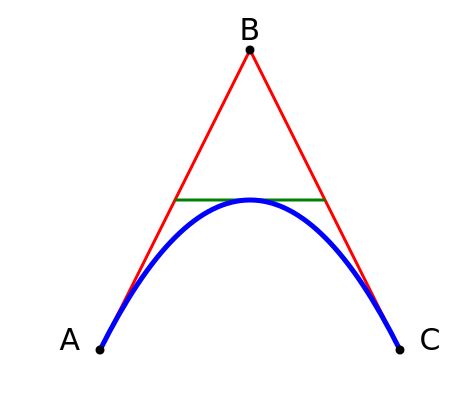

In [22]:
(svg "<svg height=\"400\" width=\"450\">
<path id=\"lineAB\" d=\"M 100 350 l 150 -300\" stroke=\"red\" stroke-width=\"3\" fill=\"none\" />
  <path id=\"lineBC\" d=\"M 250 50 l 150 300\" stroke=\"red\" stroke-width=\"3\" fill=\"none\" />
  <path d=\"M 175 200 l 150 0\" stroke=\"green\" stroke-width=\"3\" fill=\"none\" />
  <path d=\"M 100 350 q 150 -300 300 0\" stroke=\"blue\" stroke-width=\"5\" fill=\"none\" />
  <!-- Mark relevant points -->
  <g stroke=\"black\" stroke-width=\"3\" fill=\"black\">
    <circle id=\"pointA\" cx=\"100\" cy=\"350\" r=\"3\" />
    <circle id=\"pointB\" cx=\"250\" cy=\"50\" r=\"3\" />
    <circle id=\"pointC\" cx=\"400\" cy=\"350\" r=\"3\" />
  </g>
  <!-- Label the points -->
  <g font-size=\"30\" font=\"sans-serif\" fill=\"black\" stroke=\"none\" text-anchor=\"middle\">
    <text x=\"100\" y=\"350\" dx=\"-30\">A</text>
    <text x=\"250\" y=\"50\" dy=\"-10\">B</text>
    <text x=\"400\" y=\"350\" dx=\"30\">C</text>
  </g>
</svg>")

Of course, it is quite cumbersome to write full pictures in a string encoding an xml document ! Pictures can be obtained more interesting in a programmatic manner, either building a string or relying on a third-party library.  This could be an XML library but there is also a nifty `cl-svg` library that we might use.

In [23]:
(ql:quickload "cl-svg")

("cl-svg")

In [24]:
(defparameter *scene* 
    (let* ((scene (svg:make-svg-toplevel 'svg:svg-1.1-toplevel :height 200 :width 200))
           (lg1 (svg:make-linear-gradient scene (:id :generate
                                         :x1 "0%" :y1 "0%" :x2 "100%" :y2 "100%")
                (svg:stop :color "green" :offset "0%")
                (svg:stop :color "blue" :offset "50%")
                (svg:stop :color "red" :offset "100%"))))
     (svg:title scene "SVG test: gradients")
     (svg:draw scene (:rect :x 10 :y 10 :height 200 :width 200)
               :fill (svg:xlink-href lg1))
        scene))

*SCENE*

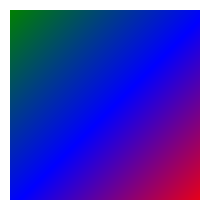

In [25]:
(svg (with-output-to-string (out)
         (svg:stream-out out *scene*))))

Finally, it is perhaps easier to load a SVG picture directly from a file.

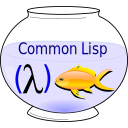

In [1]:
(svg-from-file "profile/fishbowl-small.svg")

### Bitmap images

#### PNG files

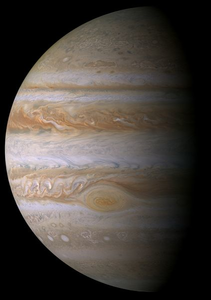

In [1]:
(png-from-file "profile/Portrait_of_Jupiter_from_Cassini.png")

#### JPEG files

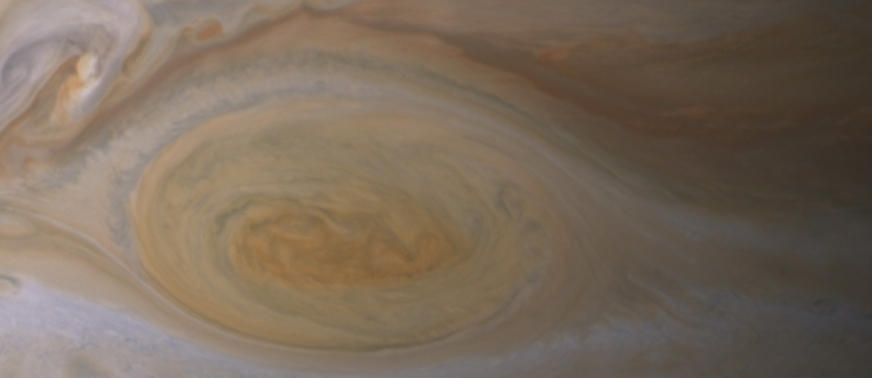

In [2]:
(png-from-file "profile/Jupiter's_storm.jpg")

(courtesy of the Nasa)

## To be continued ...